In [145]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, AdditiveAttention, Input, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import pearsonr
import keras
from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner import RandomSearch
from keras import backend as K

In [146]:
df = pd.read_parquet('stock_data_2015-2024.parquet')
df

,time,open,high,low,close,volume,ID,target
0,2015-10-21,5.22,5.31,5.21,5.22,103000,AAA,0.009533
1,2015-10-21,3.93,3.94,3.89,3.92,282119,ACB,0.010127
2,2015-10-21,5.26,5.30,5.26,5.26,602630,ASM,0.042797
3,2015-10-21,14.74,14.93,14.62,14.74,749170,BID,0.024792
4,2015-10-21,19.27,19.51,19.03,19.11,2754350,CII,-0.004160
...,...,...,...,...,...,...,...,...
87425,2024-10-18,18.50,18.50,18.20,18.20,2360620,VCG,0.102166
87426,2024-10-18,41.70,42.20,41.70,41.80,1176381,VIC,0.038806
87427,2024-10-18,11.60,11.60,11.40,11.40,8811902,VIX,0.033902
87428,2024-10-18,14.95,15.05,14.85,14.85,7748968,VND,0.125557


In [147]:
list_id = df['ID'].unique()
list_id

array(['AAA', 'ACB', 'ASM', 'BID', 'CII', 'CTG', 'DBC', 'DIG', 'DPM',
       'DXG', 'EIB', 'FPT', 'GMD', 'HAG', 'HCM', 'HPG', 'HSG', 'KBC',
       'MBB', 'MWG', 'NKG', 'NLG', 'PDR', 'PVD', 'PVT', 'SBT', 'SHB',
       'SSI', 'STB', 'VCB', 'VCG', 'VIC', 'VIX', 'VND', 'VNM'],
      dtype=object)

In [148]:
AAA_df = df[df['ID'] == 'AAA']
AAA_df

,time,open,high,low,close,volume,ID,target
0,2015-10-21,5.22,5.31,5.21,5.22,103000,AAA,0.009533
35,2015-10-22,5.17,5.38,5.23,5.27,78480,AAA,0.019158
70,2015-10-23,5.22,5.33,5.23,5.27,134800,AAA,-0.019343
105,2015-10-26,5.32,5.32,5.22,5.27,74300,AAA,-0.028601
140,2015-10-27,5.27,5.25,5.05,5.12,97400,AAA,-0.009533
...,...,...,...,...,...,...,...,...
87221,2024-10-15,9.50,9.51,9.37,9.37,1600185,AAA,-0.021277
87290,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214
87291,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214
87360,2024-10-17,9.23,9.37,9.23,9.30,1201402,AAA,-0.089477


In [149]:
AAA_df['ma_14'] = ta.sma(AAA_df['close'], length = 14, append = True)
AAA_df

C:\Users\Asus\AppData\Local\Temp\ipykernel_33608\478631812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAA_df['ma_14'] = ta.sma(AAA_df['close'], length = 14, append = True)


,time,open,high,low,close,volume,ID,target,ma_14
0,2015-10-21,5.22,5.31,5.21,5.22,103000,AAA,0.009533,NaN
35,2015-10-22,5.17,5.38,5.23,5.27,78480,AAA,0.019158,NaN
70,2015-10-23,5.22,5.33,5.23,5.27,134800,AAA,-0.019343,NaN
105,2015-10-26,5.32,5.32,5.22,5.27,74300,AAA,-0.028601,NaN
140,2015-10-27,5.27,5.25,5.05,5.12,97400,AAA,-0.009533,NaN
...,...,...,...,...,...,...,...,...,...
87221,2024-10-15,9.50,9.51,9.37,9.37,1600185,AAA,-0.021277,9.472857
87290,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214,9.461429
87291,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214,9.450000
87360,2024-10-17,9.23,9.37,9.23,9.30,1201402,AAA,-0.089477,9.440714


In [150]:
AAA_df.reset_index(drop=True)

,time,open,high,low,close,volume,ID,target,ma_14
0,2015-10-21,5.22,5.31,5.21,5.22,103000,AAA,0.009533,NaN
1,2015-10-22,5.17,5.38,5.23,5.27,78480,AAA,0.019158,NaN
2,2015-10-23,5.22,5.33,5.23,5.27,134800,AAA,-0.019343,NaN
3,2015-10-26,5.32,5.32,5.22,5.27,74300,AAA,-0.028601,NaN
4,2015-10-27,5.27,5.25,5.05,5.12,97400,AAA,-0.009533,NaN
...,...,...,...,...,...,...,...,...,...
2493,2024-10-15,9.50,9.51,9.37,9.37,1600185,AAA,-0.021277,9.472857
2494,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214,9.461429
2495,2024-10-16,9.35,9.40,9.24,9.24,1799435,AAA,-0.003214,9.450000
2496,2024-10-17,9.23,9.37,9.23,9.30,1201402,AAA,-0.089477,9.440714


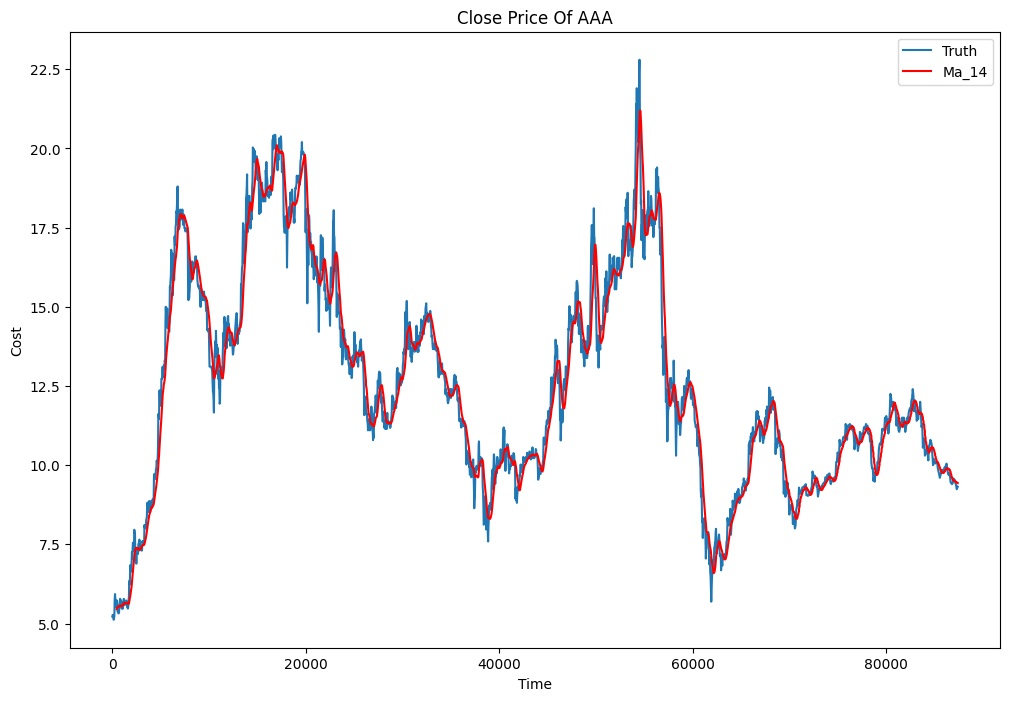

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(AAA_df['close'], label = 'Truth')
plt.plot(AAA_df['ma_14'], color = 'red', label = 'Ma_14')
plt.title('Close Price Of AAA')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.legend()
plt.show()

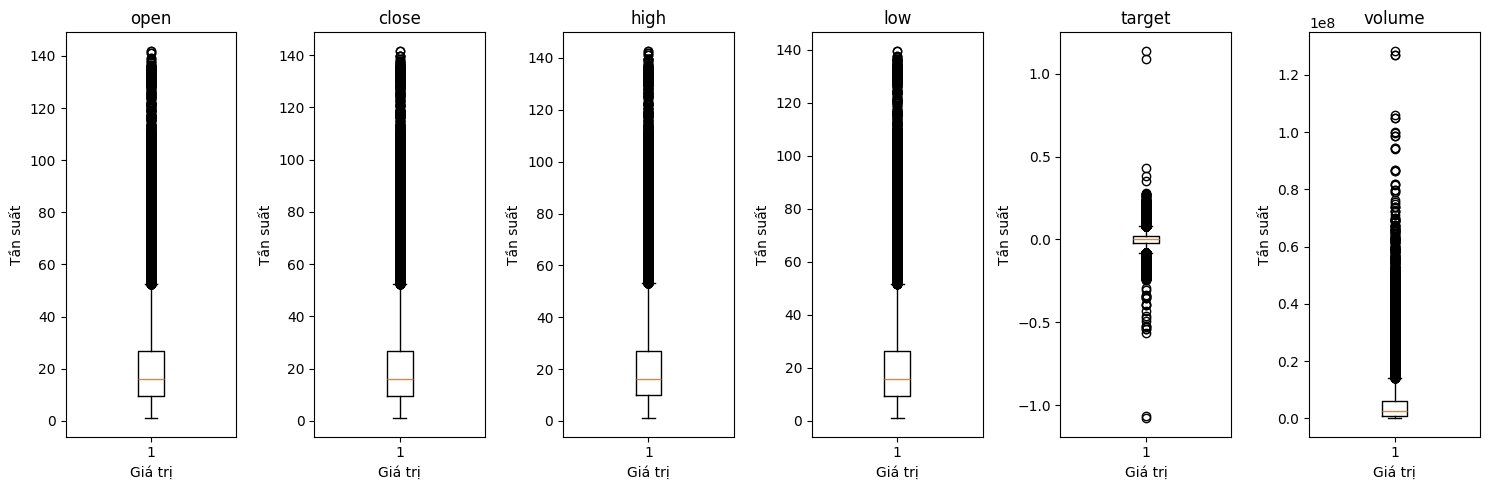

In [ ]:
col  = ['open','close','high','low','target','volume']
n = len(col)
plt.figure(figsize=(15, 5))

for index, i in enumerate(col):
    plt.subplot(1, n, index + 1)
    plt.boxplot(df[i])
    plt.title(i)
    plt.xlabel('Giá trị')
    plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()

In [153]:
AAA_df = AAA_df.drop(['volume', 'target','ma_14','ID'], axis=1)

In [154]:
train_df = AAA_df.loc[AAA_df['time'] < '2023-01-01']
val_df = AAA_df.loc[(AAA_df['time'] > '2022-12-31') & (AAA_df['time'] < '2024-01-01')]
test_df = AAA_df.loc[AAA_df['time'] > '2023-12-31']

In [155]:
train_df

,time,open,high,low,close
0,2015-10-21,5.22,5.31,5.21,5.22
35,2015-10-22,5.17,5.38,5.23,5.27
70,2015-10-23,5.22,5.33,5.23,5.27
105,2015-10-26,5.32,5.32,5.22,5.27
140,2015-10-27,5.27,5.25,5.05,5.12
...,...,...,...,...,...
62930,2022-12-26,7.20,7.20,6.68,6.68
62965,2022-12-27,6.70,6.89,6.69,6.88
63000,2022-12-28,6.93,6.97,6.83,6.92
63035,2022-12-29,6.90,7.00,6.80,6.86


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
train_close = scaler.fit_transform(train_df[['close']])

val_close = scaler.transform(val_df[['close']])

test_close = scaler.transform(test_df[['close']])

train = pd.DataFrame(train_close, columns=['close'])

In [157]:
x_train = []
y_train = [] 

for i in range(100, train_close.shape[0]):
    x_train.append(train_close[i-100: i])
    y_train.append(train_close[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [158]:
x_train.shape

(1703, 100, 1)

In [159]:
x_val = []
y_val = [] 

for i in range(100, val_close.shape[0]):
    x_val.append(val_close[i-100:i])
    y_val.append(val_close[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val) 

In [160]:
x_test = []
y_test = [] 

for i in range(100, test_close.shape[0]):
    x_test.append(test_close[i-100: i])
    y_test.append(test_close[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test) 

In [161]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
                ,input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))


    model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
    model.add(Dropout(0.3))


    model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
    model.add(Dropout(0.4))


    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])
    return model

In [ ]:
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        model.add(LSTM(units=hp.Int('units_lstm1', min_value=32, max_value=128, step=16), 
                       activation='relu', return_sequences=True,
                       input_shape=(x_train.shape[1], 1)))
        model.add(Dropout(0.2))

        model.add(LSTM(units=hp.Int('units_lstm2', min_value=32, max_value=128, step=16), 
                       activation='relu', return_sequences=True))
        model.add(Dropout(0.3))

        model.add(LSTM(units=hp.Int('units_lstm3', min_value=64, max_value=256, step=32), 
                       activation='relu', return_sequences=True))
        model.add(Dropout(0.4))

        model.add(LSTM(units=hp.Int('units_lstm4', min_value=64, max_value=256, step=32), 
                       activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
        return model


In [166]:
lstm_hypermodel = LSTMHyperModel()
tuner = RandomSearch(
    lstm_hypermodel,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=1,
    directory='my_dir',  
    project_name='LSTM_hyperparameter_tuning'
)


In [ ]:
model = LSTMHyperModel()

In [113]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

callbacks = [early_stopping, reduce_lr]

In [114]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val), 
    epochs=50,
    batch_size=64,
    callbacks = callbacks,
    verbose=1
)

Epoch 1/50


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - MAE: 0.3006 - loss: 0.1326 - val_MAE: 0.2023 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - MAE: 0.1230 - loss: 0.0233 - val_MAE: 0.0752 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - MAE: 0.0968 - loss: 0.0148 - val_MAE: 0.0399 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - MAE: 0.0810 - loss: 0.0111 - val_MAE: 0.0373 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - MAE: 0.0747 - loss: 0.0098 - val_MAE: 0.0291 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - MAE: 0.0783 - loss: 0.0103 - val_MAE: 0.0341 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - MAE: 0.0743 - loss: 0.0095 - val_MAE: 0.0287 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 8/50
27/27 

In [115]:
model.evaluate(x_test,y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - MAE: 0.0189 - loss: 5.4162e-04


[0.0004682430881075561, 0.017924116924405098]

In [116]:
y_pred = model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [117]:
scaler.scale_

array([0.05656109])

In [118]:
scale_factor = 1/0.05656109
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

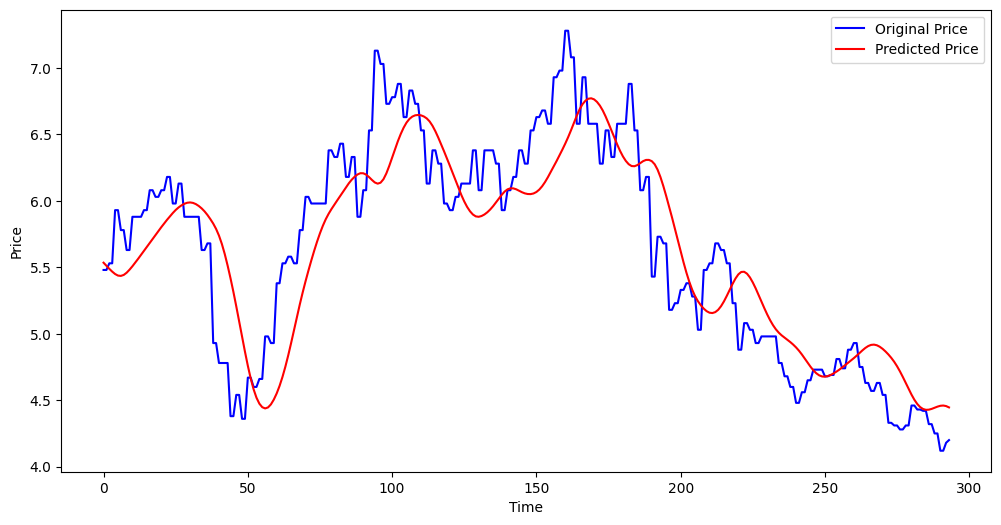

In [119]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [120]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 5.62%


In [121]:
from sklearn.metrics import r2_score
actual = y_test
predicted = y_pred
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 77.1835318149444 %
